#Bayesian Inference with MCMC

This blog post is an attempt at trying to explain the intuition behind MCMC sampling: specifically, a particular instance of the __Metropolis-Hasting algorithm__. Critically, we'll be using `TensonFlow Probability` code examples to explain the various concepts. 

## The Problem

First, let's import our modules. Note that we will use TensorFlow 2 Beta and we will use the TFP nightly distribution with works fine with TF2.

In [ ]:
!pip install tensorflow==2.0.0-beta0 
!pip install tfp-nightly

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

import matplotlib.pyplot as plt
import seaborn as sns

tf.random.set_seed(1994)
sns.set_context('paper')
sns.set_style('whitegrid')

Let's generate some data: 20 points from a Gaussian distribution centered around zero.
Note that in TFP the Gaussian distribution is parametrized by mean and standard deviation, not the variance.


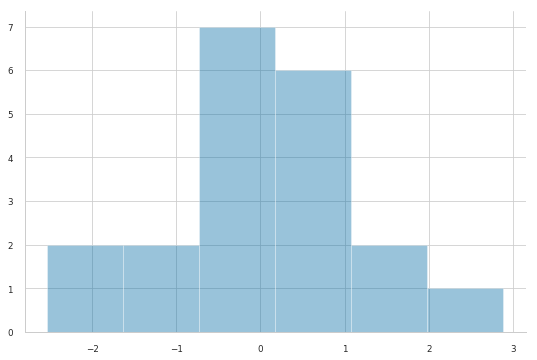

In [ ]:
observed = tfd.Normal(loc=0., scale=1.).sample(20)
sns.distplot(observed, kde=False)
sns.despine();

We have some observations $x$.

Usually (in parametric statistics) we assume a data-generating process, i.e. a model $P(x|\theta)$, from which the data we see had been sampled. Looking at the data we come up, somehow, with the idea that a good model for our data is the Gaussian distribution. In other words, we assume that the data are normally distributed.

The model often depends on unknown parameters $\theta$. They can be unknown because they are intrinsecally random or because simply we do not know them. A normal distribution has two parameters: the mean, $\mu$, and the standard deviation, $\sigma$. For simplicity, we assume we know $\sigma=1$ and we want to make inference on $\mu$ only, that is $\theta \equiv \mu$.

From a Bayesian viewpoint, we have to assign a prior distribution for this parameter, i.e. $P(\theta)$. Let's also assume a normal distribution as a prior for $\mu$. Our model can be written as follows (we assumed that the prior is a Gaussian distribution with mean 4 and stardard deviation 2)

$$
\begin{align}
  x_i|\mu &\stackrel{i.i.d.}{\sim} \mathcal{N}(\mu, \sigma=1)\\
  \mu &\sim \mathcal{N}(\mu_0 = 4, \sigma_0 = 2)
\end{align}
$$



In the Bayesian Stat lingo, this way of writing the model derives from the fact that knowing nothing about the joint distribution of $x$ we can assume [exchangeability](https://en.wikipedia.org/wiki/Exchangeable_random_variables). By the [De Finetti's Theorem](https://en.wikipedia.org/wiki/De_Finetti%27s_theorem) we arrive to the above formulation. Anyway, this goes beyond the scope of this blog post. For more information on Bayesian Analysis look at [Gelman et al. book](http://www.stat.columbia.edu/~gelman/book/).

In [ ]:
#Prior
mu_0, sigma_0 = 4., 2.
prior = tfd.Normal(mu_0, sigma_0)

#Likelihood params
mu, sigma = tf.reduce_mean(observed), 1. #use the sample mean as guess for mu
likelihood = tfd.Normal(mu, sigma) 

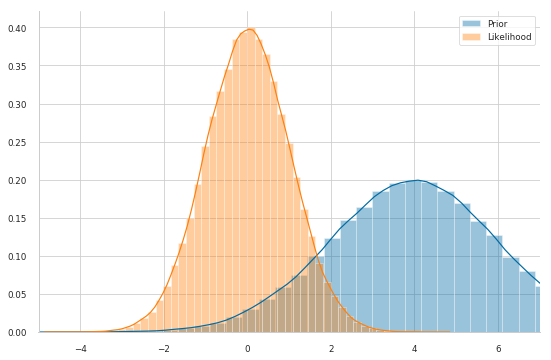

In [ ]:
sns.distplot(prior.sample(10**5))
sns.distplot(likelihood.sample(10**5))
sns.despine()
plt.legend(labels=['Prior','Likelihood'])
plt.xlim(-5, 7);

In the Bayesian framework, inference, i.e. knowing something more about the unknown parameters, is solved by the Bayes formula

$$P(\theta|x)=\frac{P(x|\theta)P(\theta)}{P(x)}$$

The posterior distribution $P(\theta|x)$ -- that is, what we know about our model parameters $\theta$ after having seen thet data $x$ -- is our quantity of interest. 

To compute it, we multiply the __prior__ $P(\theta)$ (what we think about $\theta$ before we have seen any data) and the __likelihood__ $P(x|\theta)$, dividing by the __evidence__ $P(x)$ (i.e. the evidence that the data x was generated by this model).



However, let's take a closer look at the denominator, $P(x)$. We do not observe it, but we can compute this quantity by integrating over all possible parameter values:

$$P(x)=\int_\Theta P(x,\theta) \ d\theta$$

This is the key difficulty with the Bayes formula -- while the formula looks pretty enough, for even slightly non-trivial models we cannot compute the posterior in a closed-form way.



__NOTE__: $P(x)$ is a normalizing constant. Up to this normalizing constant, we know exactly how the _unnormalized_ posterior distribution looks like, i.e.

$$P(\theta|x) \propto P(x|\theta) P(\theta)$$

(where $\propto$ mean "proportional to"). Since we defined both terms on the rhs, __we do know how to sample from the unnormalized posterior distribution__

Furthermore, by the product rule  -- $P(A, B) = P(A|B) P(B)$ -- we can write

$$P(\theta|x) \propto P(x, \theta)$$

meaning that the unnormalized posterior is proportional to the joint distribution of $x$ and $\theta$. 


nack to the example. The prior distribution we defined is convenient because we can actually compute the posterior distribution analytically. That's because for a normal likelihood with known standard deviation, the normal prior distribution for $\mu$ is [conjugate](https://en.wikipedia.org/wiki/Conjugate_prior), i.e. our posterior distribution will belong to the same family of distributions of the prior. 

Therefore, we know that our posterior distribution for $\mu$ is also normal. We can easily look up on wikipedia how we can compute the parameters of the posterior. For a mathematical derivation see [here](https://docs.google.com/viewer?a=v&pid=sites&srcid=ZGVmYXVsdGRvbWFpbnxiYXllc2VjdHxneDplNGY0MDljNDA5MGYxYTM).

Let's define a function which computes the updates for the parameters of the posterior distribution analytically

In [ ]:
def get_param_updates(data, sigma, prior_mu, prior_sigma): #sigma is known
    n = len(data)
    sigma2 = sigma**2
    prior_sigma2 = prior_sigma**2
    x_bar = tf.reduce_mean(data)
    
    post_mu = ((sigma2 * prior_mu) + (n * prior_sigma2 * x_bar)) / ((n * prior_sigma2) + (sigma2))
    post_sigma2 = (sigma2 * prior_sigma2) / ((n * prior_sigma2) + sigma2)
    post_sigma = tf.math.sqrt(post_sigma2)
    
    return post_mu, post_sigma

In [ ]:
#Posterior
mu_n, sigma_n = get_param_updates(observed,
                                  sigma=1, 
                                  prior_mu=mu_0, 
                                  prior_sigma=sigma_0)
posterior = tfd.Normal(mu_n, sigma_n)

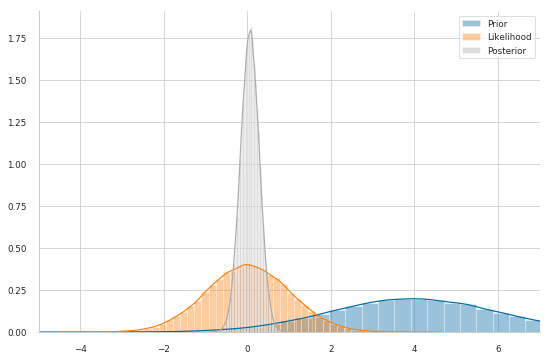

In [ ]:
sns.distplot(prior.sample(10**5))
sns.distplot(likelihood.sample(10**5))
sns.distplot(posterior.sample(10**5))
sns.despine()
plt.legend(labels=['Prior','Likelihood', 'Posterior'])
plt.xlim(-5, 7);

This shows our quantity of interest: the probability of $\mu$'s values after having seen the data, taking our prior information into account. 

The important thing to acknowledge is that, without conjugacy, we would not even be capable of sketching the posterior distribution: we would not know its shape at all. Let's assume, however, that our prior was not conjugate and we could not solve this by hand -- which is usually the case.

## Approximation methods

When we do not have access to the analytic form of the posterior distribution we can resort to MCMC methods. The basic idea is that we can find strategies to sample from the posterior distribution, even if we cannot "write it down". These samples are then used to approximate the posterior distribution. One simple strategy to get samples from the posterior distribution is the __Rejection Sampling algorithm__.

###Rejection Sampling

The basic idea of rejection sampling is to sample from an _instrumental distribution_ and reject samples
that are "unlikely" under the _target distribution_. Here we consider a very specific instance of rejection sampling:
the __Naive Rejection Sampling__.

Suppose that you can sample from a joint distribution $P(X, \theta)$ (where $X$ is random as well) -- we have seen that we can sample from it since using the product rule we get $P(X, \theta) = P(X|\theta) P(\theta)$, which are both defined by us, so we know how to sample from them!

We are interested in sampling $\theta$ from the conditional distribution $P(\theta|X = x)$, for some fixed values of $x$ -- i.e. the observed data.



The Naive Rejection Sampling algorithm works as follows:

1. Sample $\theta$ from the prior $P(\theta)$ and X from the likelihood $P(X|\theta)$ 

2. If $X = x$ (the observed data) , accept $\theta$ as a sample from the posterior $P(\theta|X = x)$ , otherwise return to (1) and repeat

Each time you return to step 1, the samples of $\theta$ are independent from the previous ones.

Pros: step 1 is often practical because both the prior and the likelihood are often easy-to-sample distributions. Cons: the clear shortcoming is can be very unlikely and thus step 2 will very rarely (if ever) accept the candidate sample $\theta$.

This simple implementation of rejection sampling is enough to provide some intuition and motivate the use of more sophisticated and robust sampling algorithms based on Markov chains.

###MCMC: The Random-Walk Metropolis-Hasting algorithm

There is a large family of algorithms that perform MCMC. Most of these algorithms can be expressed at a high level as follows:

1. Start at current position (i.e. a value for $\theta$, say $\theta^{(1)}$)

2. Propose moving to a new position (say, $\theta^*$)

3. Accept/Reject the new position based on the position's adherence to the data and prior distributions.

4. 1.  If you accept: Move to the new position (i.e. $\theta^{(2)}=\theta^*$). Return to Step 1.
  2. Else: Do not move to new position. Return to Step 1. 

5. After a large number of iterations, return all accepted positions.

Based on how you implement the above steps you get the various MCMC algorithm. Here we will review the __Random-Walk Metropolis-Hasting algorithm__.



As we have seen, the main drawback of the rejection sampling is that it is not efficient -- it is unlikely to get exactly $X = x$, especially when it is high-dimensional.

One way around this problem is to allow for "local updates", i.e. let the proposed value depend on the last accepted value. 
This makes it easier to come up with a suitable (conditional) proposal, however at the price of yielding a Markov chain, $(\theta_s)_{s\geq1}$,
instead of a sequence of independent **realizations** -- putting it simply, a sequence of random variables is a _Markov Chain_ if the future state only depends on the present state.


The RW-MH proposes a new $\theta^*$ according to

$$\theta^* = \theta_{s} + \varepsilon, \quad \varepsilon \sim g$$

where $g$ may be any simmetric distribution. Usually, $g = \mathcal{N}(0, \tau)$, so that the proposed new value is simply a draw from $\mathcal{N}(\theta_{s}, \tau)$.

At first, you find starting parameter position (can be randomly chosen), lets fix it arbitrarily to

In [ ]:
mu_current = 2.

The critical point is how you propose the new position (that's the Markov part). You can be very naive or very sophisticated about how you come up with that proposal. The RW-MH algorithm is very naive and just takes a sample from a Gaussian distribution (or whatever simmetric distribution you like) centered on the current value with a certain standard deviation, usually called _proposal width_ that will determine how far you propose jumps.

In [ ]:
proposal_width = 1.
mu_proposal = tfd.Normal(mu_current, proposal_width).sample()

Next, you evaluate whether that's a good place to jump to or not. To evaluate if it is good you compute the ratio

$$\rho = \frac{P(\theta^*|x)}{P(\theta_s|x)} = \frac{P(x|\theta^*) P(\theta^*)/P(x)}{P(x|\theta_s) P(\theta_s)/P(x)} = \frac{P(x, \theta^*)}{P(x, \theta_s)}$$

Here is the trick: the normalizing constants cancel out. We only have to compute the joint probability -- usually, the log joint probability -- of the data and the parameter values. TFP performs probabilistic inference by evaluating the model parameters using a `joint_log_prob` function, which we define below.

Then, 

* If $\rho\geq1$, set $\theta^{s+1}=\theta^*$

* If $\rho<1$, set $\theta_{s+1}=\theta^*$ with probability $\rho$, otherwise set $\theta_{s+1}=\theta_s$ (this is where we use the standard uniform distribution -- in practice you draw a sample $u \sim \mathrm{Unif}(0,1)$ and check if $\rho > u$; if it is you accept the proposal)

To sum up, we accept a proposed move to $\theta^*$ whenever the density of the (unnormalzied) joint distribution evaluated at $\theta^*$ is larger than the value of the unnormalized joint distribution evaluated at $\theta_s$ -- so $\theta$ will more often be found in places where the unnormalized joint distribution is denser.

If this was all we accepted, $\theta$ would get stuck at a local mode of the target distribution, so we also accept occasional moves to lower density regions.


In [ ]:
def joint_log_prob(data, proposal):
  prior = tfd.Normal(mu_0, sigma_0)
  likelihood = tfd.Normal(proposal, sigma)
  
  return prior.log_prob(proposal) + tf.reduce_mean(likelihood.log_prob(data))

In [ ]:
p_accept = joint_log_prob(observed, mu_proposal) / joint_log_prob(observed, mu_current)

In [ ]:
if p_accept > tfd.Uniform().sample():
  mu_current = proposal
  print('Proposal accepted')

Proposal accepted


In TFP the algorithm is implemented as follows. 

First we define _how_ the step should be taken, i.e. how the proposal should be made. Since we are implementing the RW-MH algorithm we use the function `tfp.mcmc.RandomWalkMetropolis`. It takes as argument the unnormalized join distribution that it will use to compute the acceptance ratio. The only thinkg we have to remenber is that we have to "lock the data" or "define a closure" over our joint_log_prob function. In other words, fix the data input of the function `joint_log_prob` 

In [ ]:
def unnormalized_log_posterior(proposal):
  return joint_log_prob(observed, proposal)

In [ ]:
rwm = tfp.mcmc.RandomWalkMetropolis(
    target_log_prob_fn=unnormalized_log_posterior
)

Secondly, we have to define the initial state of the chain, say $\theta_0$. We choose this arbitrarily.

In [ ]:
initial_state = tf.constant(1.)

Finally, we can sample the chain (without storing "additional information" `trace_fn=None`)

In [ ]:
trace, kernel_results = tfp.mcmc.sample_chain(
    num_results=2*10**4,
    num_burnin_steps=2000,
    current_state=initial_state,
    num_steps_between_results=5,
    kernel=rwm
)

/usr/local/lib/python3.6/dist-packages/tensorflow_probability/python/mcmc/sample.py:335: UserWarning: Tracing all kernel results by default is deprecated. Set the `trace_fn` argument to None (the future default value) or an explicit callback that traces the values you are interested in.
  warnings.warn("Tracing all kernel results by default is deprecated. Set "


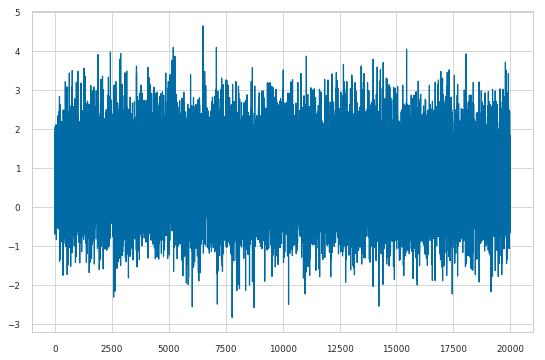

In [ ]:
plt.plot(trace);

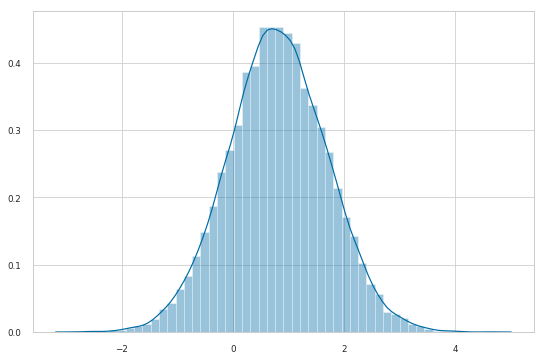

In [ ]:
sns.distplot(trace);

In [ ]:
posterior.mean().numpy()

0.063399814

In [ ]:
tf.reduce_mean(trace).numpy()

0.8029209

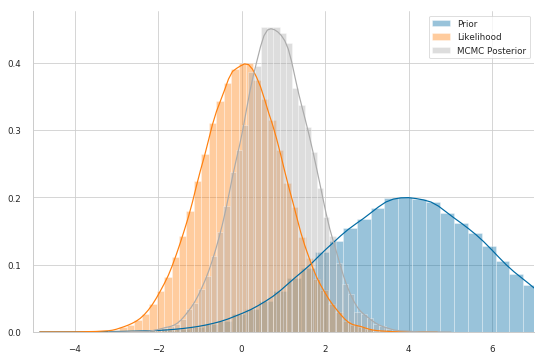

In [ ]:
sns.distplot(prior.sample(10**5))
sns.distplot(likelihood.sample(10**5))
sns.distplot(trace)
sns.despine()
plt.legend(labels=['Prior','Likelihood', 'MCMC Posterior'])
plt.xlim(-5, 7);